# Assignment 2.2 Motion Detection with Census-Matching
---
Group 3:
* Jiye Lee
* Eduardo Venegas Hernández
---

Import Libraries

In [2]:
import Pkg
Pkg.add("Images")
Pkg.add("FileIO")
Pkg.add("Plots")

using Images
using FileIO
using Plots

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


1. Apply the census transform (as implemented in task 1) to two subsequent images of a given sequence. Equal census values indicate the occurrence of identical local features

In [3]:
function censustransform(img, kernel; epsilon=0.1)
  # your code here

  # create a new image with the same size as the input image of type UInt64
  img_new = zeros(UInt64, size(img))
  
  # window is equal to size of kernel divided by 2 and floor
  window = floor(Int, size(kernel,1)/2)

  # loop over all pixels in the image
  for i in 1+window:size(img,1) - window 
      for j in 1+window:size(img,2) - window
        # get the value of the central pixel
        central_pixel = img[i,j]

        bit_string = ""

        # iterate the kernel
        for k in 1:size(kernel,1)
          for l in 1:size(kernel,2)
            # get the value of the neighboring pixel
            if ((i-window+k - 1) == i && (j-window+l  - 1) == j) continue end
            neighboring_pixel = img[i-window+k - 1,j-window+l  - 1]

            # check if the neighboring pixel is darker than the central pixel
            if neighboring_pixel < central_pixel - N0f8.(epsilon)
              bit_string *= "00"
            # check if the neighboring pixel is brighter than the central pixel
            elseif neighboring_pixel > central_pixel + N0f8.(epsilon)
              bit_string *= "01"
            else
              bit_string *= "10"
            end
          end
        end
        # bit string to integer
        img_new[i,j] = parse(UInt64, bit_string[1:16], base=2)
      end
  end

  # convert array to image
  return img_new
end

censustransform (generic function with 1 method)

2. Write a function findmatches(t1, t2; n=50, d=10) that finds matches between the descriptors at time points t1 and t2. The function should first identify possible matches (i.e., pairs of identical descriptor values). To avoid a computational blow-up, make sure that the matching is not done pixel-by-pixel. Instead, consider how you can find all matches in less then quadratic time. Explain your approach. To prevent accidental or uninformative matches, discard all census values that occur more often than n and discard all matches which indicate a motion distance of more than d=10 pixels in x or y direction. Record the remaining correspondences in a velocity space (4D matrix).

In [14]:
# Write a function findmatches(t1, t2; n=50, d=10) that finds matches between the
#   descriptors at time points t1 and t2. The function should first identify possible matches
#   (i.e., pairs of identical descriptor values). To avoid a computational blow-up, make sure
#   that the matching is not done pixel-by-pixel. Instead, consider how you can find all
#   matches in less then quadratic time. Explain your approach. To prevent accidental
#   or uninformative matches, discard all census values that occur more often than n and
#   discard all matches which indicate a motion distance of more than d=10 pixels in x or
#   y direction. Record the remaining correspondences in a velocity space (4D matrix).

########################
### HELPER FUNCTIONS ###
########################

function discardPixels(matrixImage, n, d)
  # matrixImage is the census transform of an image with values of type UInt64
  # n is the maximum number of occurances of a pixel value
  # d is the maximum distance between two pixels

  # discard all pixels that occur more than n times in matrixImage
  # iterate the matrixImage image

  dict = Dict{UInt64,Int64}()
  for i in 1:size(matrixImage,1)
    for j in 1:size(matrixImage,2)
      # check if the pixel value is in the dictionary
      if haskey(dict, matrixImage[i,j])
        # if the pixel value is in the dictionary, increment the value
        dict[matrixImage[i,j]] += 1
      else
        # if the pixel value is not in the dictionary, add it
        dict[matrixImage[i,j]] = 1
      end
    end
  end
  
  
  # iterate the matrixImage image
  for i in 1:size(matrixImage,1)
    for j in 1:size(matrixImage,2)
      # check if the pixel value is in the dictionary
      if haskey(dict, matrixImage[i,j])
        # if the pixel value is in the dictionary, check if the value is greater than n
        if dict[matrixImage[i,j]] > n
          # if the value is greater than n, set the pixel value to 0
          matrixImage[i,j] = 0
        end
      end
    end
  end
  return matrixImage
end

function getMatches(t1, t2, d)
  #create 4D matrix to store the matches
  matches=zeros(Int64,size(t1,1),size(t1,2),size(t2,1),size(t2,2))

  #find all pixels in t1 that are equal to a pixel in t2 in less than quadratic time without using loops
  #iterate the t1 image
  for i in 1:size(t1,1)
    for j in 1:size(t1,2)
      # check if the pixel value is not 0
      if t1[i,j] == 0 continue end

      #searcḣ t2 in a window of size d
      for k in max(1,i-d):min(size(t2,1),i+d)
        for l in max(1,j-d):min(size(t2,2),j+d)
          # check if the pixel value is not 0
          if t2[k,l] == 0 continue end

          # check if the pixel values are equal
          if t1[i,j] == t2[k,l]
            # if the pixel values are equal, set the value of the matches matrix to 1
            matches[i,j,k,l] = 1
          end
        end
      end
    end
  end

  return matches
end

########################
#### MAIN FUNCTION #####
########################

function findmatches(t1, t2; n=50, d=10)
  # t1 and t2 are census transforms of two images with values of type UInt64
  # n is the maximum number of occurances of a pixel value
  # d is the maximum distance between two pixels

  #discard all pixels that occur more than n times in t1 and t2
  t1 = discardPixels(t1, n, d)
  t2 = discardPixels(t1, n, d)
  
  #create 4D matrix to store the matches
  matches = getMatches(t1, t2, d)

  return matches
end

findmatches (generic function with 1 method)

3. After finding all correspondences, take the average value at each location of all motion hypotheses and plot these detected motions as a vector field (u,v) using the quiver function.

In [15]:
# After finding all correspondences, take the average value at each location of all motion
# hypotheses and plot these detected motions as a vector field (u,v) using the quiver
# function.

function avgMotion(t1, t2, matches)

  #create 4D matrix to store the average motion
  avg_motion = zeros(Int64, size(t1,1), size(t1,2), 2)

  #iterate the matches matrix
  for i in 1:size(matches,1)
    for j in 1:size(matches,2)
      for k in 1:size(matches,3)
        for l in 1:size(matches,4)
          # check if the value of the matches matrix is 1
          # TODO ----------------------------------------
          if matches[i,j,k,l] == 1
            # if the value of the matches matrix is 1, add the motion to the avg_motion matrix
            avg_motion[i,j,1] += k-i
            avg_motion[i,j,2] += l-j
          end
        end
      end
    end
  end

  return avg_motion
end

avgMotion (generic function with 1 method)

In [16]:
img1 = Gray.(load("images/taxi01.png"))
img2 = Gray.(load("images/taxi02.png"))

kernel = [
  true true true;
  true true true;
  true true true;
]
  
census1 = censustransform(img1, kernel)
census2 = censustransform(img2, kernel)
matches = findmatches(census1, census2)
avg_motion = avgMotion(census1, census2, matches)

# Plot these detected motions as a vector field (u,v) using the quiver

60×80×2 Array{Int64, 3}:
[:, :, 1] =
 0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0   0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  1  1   1  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  -3  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0   0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0   0  0
 0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0   0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0   0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0   0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0   0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0   0  0
 0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0   0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0   0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0 

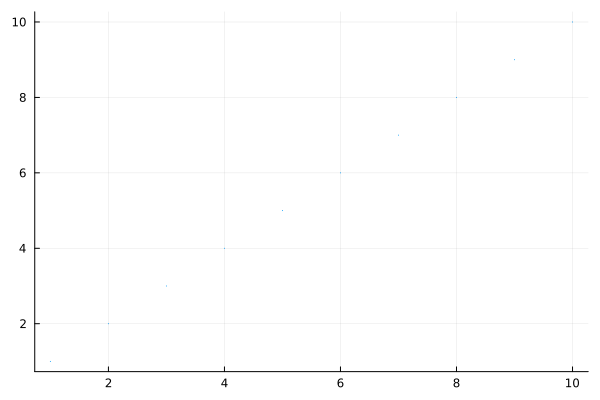

In [68]:
# quiver example
# quiver(X,Y,U,V)
# X,Y are the coordinates of the arrows
# U,V are the components of the arrows
x = 1:(size(match,1)-50)
y = 1:(size(match,2)-70)
u = match[:,:,1][1:10, 1:10]
v = match[:,:,2][1:10, 1:10]
quiver(x,y, quiver=(u,v))

4. Generate flow fields for the provided sequences: yos_clouds, hamburg and taxi with census- and rank transforms and briefly discuss the results.